In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from catboost import CatBoostClassifier
import catboost
from scipy.special import logsumexp

from src.nf import (
    FCNN,
    ConditionalNormalizingFlowModel,
    UnconditionalNormalizingFlowModel,
    cond_neg_log_likelihood,
    one_hot_encoding,
    ConditionalMAF,
    TorchDistributionWrapper,
    ConditionalNormal,
    TorchDistributionWrapper,
    NormalizingFlowModel,
    MAF,
    BaseConditionalFlow,
    wrap_cb,
    ConditionalCalibratedModel,
    deduce_calibration_constant,
    FakeCondDistribution,
    BaseConditionalDistribution,
    BaseUnconditionalDistribution,
    CalibratedModel,
    neg_log_likelihood
)

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
! nvidia-smi

Tue Jun  2 19:56:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 25%   53C    P8    10W / 250W |   5104MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 20%   29C    P8     8W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

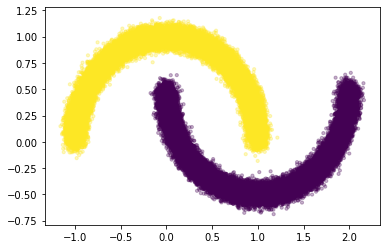

In [6]:
X, Y = make_moons(100000)
Y = one_hot_encoding(Y, 2).astype(np.float32)
n, dim, cond_dim = X.shape[0], X.shape[1], Y.shape[1]
X += np.random.normal(0, 0.05, X.shape)
X = X.astype(np.float32)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train[:, 0], alpha=0.3, s=10)

In [7]:
X_train_tensor = torch.from_numpy(X_train).to(device)
X_test_tensor = torch.from_numpy(X_test).to(device)
Y_train_tensor = torch.from_numpy(Y_train).to(device)
Y_test_tensor = torch.from_numpy(Y_test).to(device)

In [8]:
class MockNFModel(UnconditionalNormalizingFlowModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.samples_cnt = 0
    
    def sample_n(self, n):
        self.samples_cnt += n
        return super().sample_n(n)

In [9]:
flows = []
for i in range(8):
    flows.append(MAF(dim, cond_dim).to(device))

prior = TorchDistributionWrapper(
    MultivariateNormal(
        torch.FloatTensor([0.5, 0.25]).to(device),
        torch.FloatTensor([[np.sqrt(1.5), 0], [0, 1]]).to(device),
    )
)
model = MockNFModel(dim, prior, flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

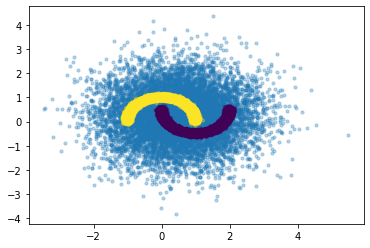

In [10]:
samples = prior.sample_n(10000).detach().cpu().numpy()

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=10)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train[:, 0], alpha=0.3, s=10)

In [11]:
epoches = 5001
metrics_ll_train, metrics_ll_test = [], []
trained_models = []

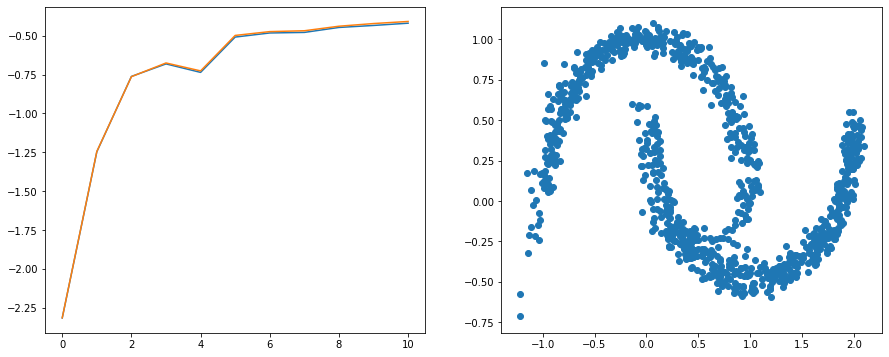

In [12]:
for i in range(len(metrics_ll_train), epoches):
    model.train()
    optimizer.zero_grad()
    logp_x = model.log_prob(X_train_tensor)
    loss = -torch.mean(logp_x)
    loss.backward()
    optimizer.step()

    if i % 500 == 0:
        trained_models.append(deepcopy(model))
        model.eval()
        with torch.no_grad():
            log_prob = model.log_prob(X_train_tensor)
            metrics_ll_train.append(torch.mean(log_prob).item())
            log_prob = model.log_prob(X_test_tensor)
            metrics_ll_test.append(torch.mean(log_prob).item())
            
            n_samples = 1000
            samples = model.sample_n(n_samples).detach().cpu().numpy()

        clear_output(False)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        
        axs[0].plot(metrics_ll_train)
        axs[0].plot(metrics_ll_test)
        
        axs[1].scatter(samples[:, 0], samples[:, 1])
        plt.show()

In [13]:
trained_clfs = []
clfs_auc = []

for model in trained_models:
    model.eval()
    n_samples = X_train.shape[0]
    with torch.no_grad():
        samples = model.sample_n(n_samples).detach().cpu().numpy()
    X_clf = np.vstack([X_train, samples])
    Y_clf = np.hstack([np.ones(n_samples), np.zeros(n_samples)])

    X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split(X_clf, Y_clf, test_size=0.2)
    
    clf = CatBoostClassifier(
        100, eval_metric='AUC',
        metric_period=50,
        use_best_model=False
    ).fit(
        X_train_clf, Y_train_clf,
        eval_set=(X_test_clf, Y_test_clf)
    )
    clfs_auc.append(roc_auc_score(Y_test_clf, clf.predict_proba(X_test_clf)[:, 1]))
    trained_clfs.append(clf)

Learning rate set to 0.5
0:	test: 0.7516375	best: 0.7516375 (0)	total: 58.2ms	remaining: 5.76s
50:	test: 0.9480162	best: 0.9480162 (50)	total: 891ms	remaining: 856ms
99:	test: 0.9491787	best: 0.9491787 (99)	total: 1.68s	remaining: 0us

bestTest = 0.9491786639
bestIteration = 99

Learning rate set to 0.5
0:	test: 0.6586038	best: 0.6586038 (0)	total: 26.9ms	remaining: 2.67s
50:	test: 0.8447505	best: 0.8447505 (50)	total: 1.1s	remaining: 1.06s
99:	test: 0.8486931	best: 0.8486931 (99)	total: 2.16s	remaining: 0us

bestTest = 0.8486931337
bestIteration = 99

Learning rate set to 0.5
0:	test: 0.5765965	best: 0.5765965 (0)	total: 20.1ms	remaining: 1.99s
50:	test: 0.7288513	best: 0.7288513 (50)	total: 1.02s	remaining: 983ms
99:	test: 0.7345157	best: 0.7345157 (99)	total: 2.02s	remaining: 0us

bestTest = 0.7345156566
bestIteration = 99

Learning rate set to 0.5
0:	test: 0.5924971	best: 0.5924971 (0)	total: 22.2ms	remaining: 2.19s
50:	test: 0.6938120	best: 0.6938120 (50)	total: 1.03s	remaining: 9

In [18]:
cliped_clfs = [
    {
        'inf': wrap_cb(clf),
        'log 2': wrap_cb(clf, np.log(2)),
        'log 4': wrap_cb(clf, np.log(4))
    } for clf in trained_clfs
]

In [19]:
qs = {
    '1': [],
    '25': [],
    '50': [],
    '75': [],
    '99': []
}
for i, (model, clfs, ll, auc) in enumerate(zip(trained_models, cliped_clfs, metrics_ll_test, clfs_auc)):
    all_logits = {}
    for name, clf in clfs.items():
        samples = model.sample_n(1000).detach().cpu().numpy()
        logits = clf(samples)
        calib_constant = logsumexp(logits) - np.log(len(logits))
        logits -= calib_constant
        all_logits[name] = logits
        
    qs['1'].append({
        name: np.quantile(logits, 0.01)
        for name, logits in all_logits.items()
    })
    qs['25'].append({
        name: np.quantile(logits, 0.25)
        for name, logits in all_logits.items()
    })
    qs['50'].append({
        name: np.quantile(logits, 0.5)
        for name, logits in all_logits.items()
    })
    qs['75'].append({
        name: np.quantile(logits, 0.74)
        for name, logits in all_logits.items()
    })
    qs['99'].append({
        name: np.quantile(logits, 0.99)
        for name, logits in all_logits.items()
    })

In [16]:
calib_lls = {name: [] for name in cliped_clfs[0].keys()}
real_samples_frac = {name: [] for name in cliped_clfs[0].keys()}

for i, (model, clfs, ll, auc) in enumerate(zip(trained_models, cliped_clfs, metrics_ll_test, clfs_auc)):
    for name, clf in clfs.items():
        calib_model = CalibratedModel(clf, model, logit=True, n_samples_c=1000)

        samples = model.sample_n(10000).detach().cpu().numpy()
        logits = clf(samples)
        calib_constant = logsumexp(logits) - np.log(len(logits))
        calib_lls[name].append(
            neg_log_likelihood(calib_model, X_test_tensor) - calib_constant
        )
        n_samples_start = calib_model.model.samples_cnt
        calib_model.sample_n(10000)
        real_samples_frac[name].append((calib_model.model.samples_cnt - n_samples_start) / 10000)

/home/robdrynkin/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


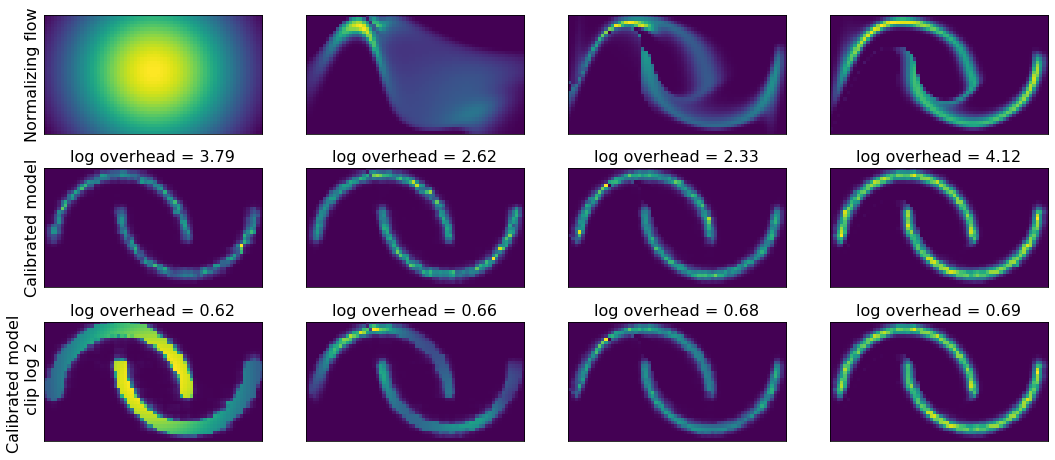

In [50]:
fig, axs = plt.subplots(3, 4, figsize=(18, 8), sharey=True)

X_val = np.transpose(np.dstack(np.meshgrid(
    np.arange(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 0.05),
    np.arange(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 0.05),
)), axes=[1, 0, 2]).astype(np.float32)

cherry_pick = {j: i for i, j in enumerate([0, 1, 4, 9])}

for i, (model, clfs, ll, auc, c_ll) in enumerate(zip(trained_models, cliped_clfs, metrics_ll_test, clfs_auc, calib_lls['inf'])):
    
    if i not in cherry_pick:
        continue
    
    i = cherry_pick[i]
    
    if i == 0:
        axs[0, i].set_ylabel('Normalizing flow', fontsize=16)
        axs[1, i].set_ylabel('Calibrated model', fontsize=16)
        axs[2, i].set_ylabel('Calibrated model \n clip log 2', fontsize=16)
    
    n_samples = X_train.shape[0]
    samples = model.sample_n(n_samples).detach().cpu().numpy()    
    logits_inf = clfs['inf'](samples)
    calib_constant_inf = logsumexp(logits_inf) - np.log(len(logits_inf))
    logits_log2 = clfs['inf'](samples)
    calib_constant_log2 = logsumexp(logits_log2) - np.log(len(logits_log2))


    logits_inf = clfs['inf'](X_val.reshape(-1, 2)) - calib_constant_inf
    logits_log2 = clfs['log 2'](X_val.reshape(-1, 2)) - calib_constant_log2

    model.eval()
    with torch.no_grad():
        log_probs = model.log_prob(
            torch.from_numpy(
                X_val.reshape(-1, 2),
            ).to(device)
        ).detach().cpu().numpy()
        probs = np.exp(log_probs).reshape(X_val.shape[0], X_val.shape[1])
        probs_fixed_inf = np.exp(log_probs + logits_inf).reshape(X_val.shape[0], X_val.shape[1])
        probs_fixed_log2 = np.exp(log_probs + logits_log2).reshape(X_val.shape[0], X_val.shape[1])

    axs[0, i].imshow(probs.T[::-1])
    
    axs[1, i].imshow(probs_fixed_inf.T[::-1])
    axs[1, i].set_title(f'log overhead = {round(np.max(logits_inf), 2)}', fontsize=16)

    axs[2, i].imshow(probs_fixed_log2.T[::-1])
    axs[2, i].set_title(f'log overhead = {round(np.max(logits_log2), 2)}', fontsize=16)
    
    for j in range(3):
        axs[j, i].set_xticks([], [])
        axs[j, i].set_yticks([], [])